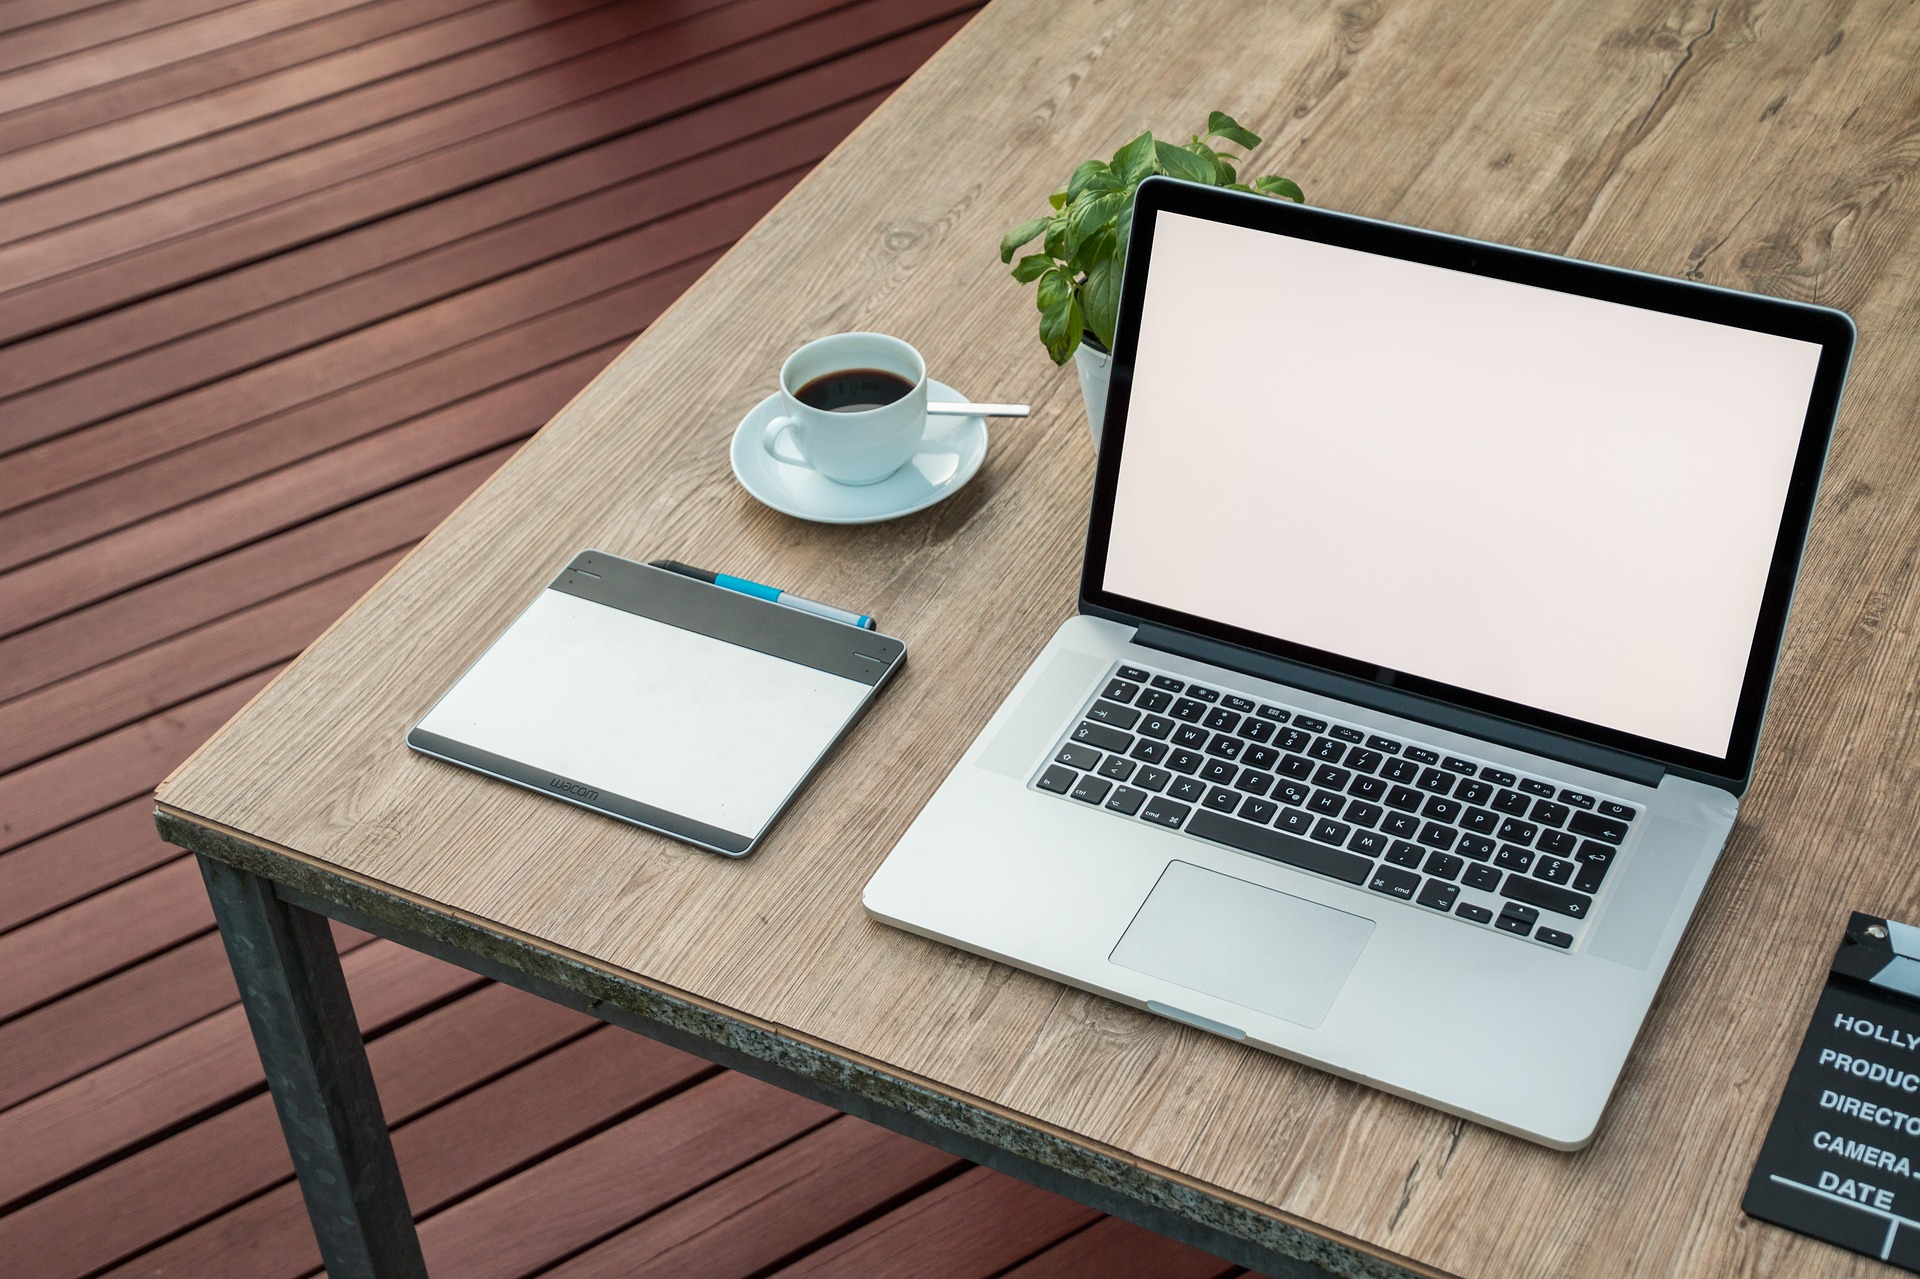

# <center> UDACITY Data Analysis Nanodegree </center> 
## <center> Project:- Analyze A/B Test Results </center>
#### Grant Patience, 30th July 2019




***
## Table of Contents

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)
- [References](#references)

## Analyze A/B Test Results to Determine the Conversion Rate of a New Web Page


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [170]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Now, read in the `ab_data.csv` data. Store it in `df`.  

In [171]:
df = pd.read_csv('ab_data.csv')
df.head(5)

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

The number of rows in the dataset.

In [172]:
df.shape[0]

294478

The number of unique users in the dataset.

In [173]:
df.user_id.nunique()

290584

The proportion of users converted.

In [174]:
df_control = df.query('group == "control"')
df_treat = df.query('group == "treatment"')
df_control_wrong = df_control.query('landing_page == "new_page"')
df_treat_wrong = df_treat.query('landing_page == "old_page"')
df_control_wrong.shape[0] + df_treat_wrong.shape[0]

3893

The number of times the `new_page` and `treatment` don't match.

In [175]:
df_control = df.query('group == "control"')
df_treat = df.query('group == "treatment"')
df_control_wrong = df_control.query('landing_page == "new_page"')
df_treat_wrong = df_treat.query('landing_page == "old_page"')
df_control_wrong.shape[0] + df_treat_wrong.shape[0]

3893

Do any of the rows have missing values?

In [176]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

Drop rows with the wrong values

In [177]:
df2 = df.drop(df_control_wrong.index)
df2.drop(df_treat_wrong.index, inplace = True)

In [178]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [179]:
df2.user_id.nunique()

290584

There is one **user_id** repeated in **df2**.  What is it?

In [180]:
#Find dups and put into a df in case we need in future
dup_df = df2[df2.user_id.duplicated(keep = False)]

What is the row information for the repeat **user_id**? 

In [181]:
#Show me the dups
dup_df

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

Remove **one** of the rows with a duplicate **user_id**, but keep dataframe as **df2**.

In [182]:
#Drop duplicates on user id, removing inplace from df
df2.drop_duplicates(subset = "user_id", inplace = True)

In [183]:
#Confirm our user id still exists but only once
df2.query('user_id == 773192')

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0

What is the probability of an individual converting regardless of the page they receive?

In [184]:
conv = df2.converted.mean()
conv

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [185]:
control_conv = df2.query('group == "control"').converted.mean()
control_conv

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [186]:
treat_conv = df2.query('group == "treatment"').converted.mean()
treat_conv

0.11880806551510564

What is the probability that an individual received the new page?

In [187]:
p_new_page = df2[df2['landing_page'] == 'new_page'].user_id.count()\
/df2.user_id.count()
p_new_page

0.5000619442226688

**Observations**

- If we look at these descriptive statistics results, the split of those who are in the control group and the treatment group is about 50%, giving an equal representation of each. 
- The conversion rate for the control group is around 12%, while for treatment group is just around 11.88%. 
- This would lead us to believe that there is no significant impact of using the new page on the treatment group, since conversion rate is not significantly positivly affected.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Hypothesis**

- We will let $H_0$ be the null hypothesis is that there is no difference in the proportion of conversions between the new page and old page. 
- We will let $H_1$ be the alternative hypothesis is that the new page will lead to an increase in proporsion of conversions. 

Using mathematical notation, this can be written as follows:

$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old} > 0$$


Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


What is the **conversion rate** for $p_{new}$ under the null? 

In [188]:
# Get the converted rate regardless of the page
p_new = df2.converted.mean()
p_new 

0.11959708724499628

What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [189]:
# Get the converted rate regardless of the page and store it as pnew_h0 
p_old = df2.converted.mean()
p_old 

0.11959708724499628

What is $n_{new}$, the number of individuals in the treatment group?

In [190]:
# count the number of users who recieved the new_page
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]
n_new

145310

What is $n_{old}$, the number of individuals in the control group?

In [191]:
# count the number of users who recieved the old_page
n_old = df2[df2['landing_page'] != 'new_page'].shape[0]
n_old

145274

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [192]:
# Get sample choice between [0,1]
# with sample size equal to number of users in df
# given probability 
new_page_converted = np.random.choice([0,1], size = n_new, p=[1-p_new,p_new])

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [193]:
# Get sample choice between [0,1]
# with sample size equal to number of users in df
# given probability 
old_page_converted = np.random.choice([0,1], size = n_old,replace=True, p=[1-p_old,p_old])

Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [194]:
sample_diff = new_page_converted.mean() - old_page_converted.mean()
sample_diff

-0.0014680647599858987

Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [195]:
p_diffs = []
for _ in range (10000):
    new_page_converted = np.random.choice([0,1], size = n_new, replace=True, p=[1-p_new,p_new])
    old_page_converted = np.random.choice([0,1], size = n_old, replace=True, p=[1-p_old, p_old])
    p_diff = new_page_converted.mean()- old_page_converted.mean()
    p_diffs.append(p_diff)

In [196]:
p_diffs = np.asarray(p_diffs)

In [197]:
actual_diff = treat_conv - control_conv

Plot a histogram of the **p_diffs**.  

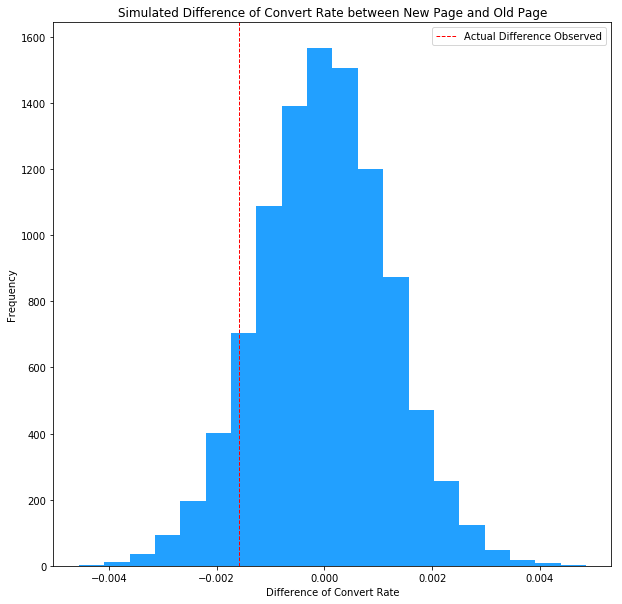

In [198]:
# plot histogram of the p_diffs
plt.subplots(figsize=(10, 10))
plt.hist(p_diffs, color='#22a0ff', bins=20)
plt.xlabel('Difference of Convert Rate')
plt.ylabel('Frequency')
plt.title('Simulated Difference of Convert Rate between New Page and Old Page')
# plot the line of actual difference
plt.axvline(actual_diff , c='red', linestyle='dashed', linewidth=1, label="Actual Difference Observed")
plt.legend()
plt.show()

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [199]:
(p_diffs > actual_diff).mean()

0.9057

**Observations**

 - We have calculated something called the P-Value. The P-Value is the probability of observing our chosen statistic (or one more extreme in favour of the alternative) if the Null hypothesis is true. The smaller the P-Value, the stronger the evidence against the null hypothesis and in favour of the alternative hypothesis.
 - Typically we would expect the P-Value to be lower than the level of $\alpha$ (typically 0.05). The $\alpha$ indicates the percentage chance of committing a Type I error if the null is true. 

 - We have calculated our P-Value to be 0.9 which is large. This tells us that a high proportion (90%) of the converted differences in the Null hypothesis distribution are larger than the actual difference observed. This effectively tells us that there is a high probability conversion rate will be larger under null hypothesis.
 
 - Therefore, given the P-Value 0.9, as such, we  fail to reject the null and conclude that there is insufficient evidence that there is a difference between the groups.


We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [200]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').converted.count()
convert_new = df2.query('landing_page == "new_page" & converted == 1').converted.count()

Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [201]:
z_score, p_value = sm.stats.proportions_ztest \
([convert_new, convert_old], [n_new, n_old], alternative='larger')
print('z-score: ',z_score ,', p-value: ', p_value)

z-score:  -1.3109241984234394 , p-value:  0.9050583127590245


**Observations**

The calculated values align with those obtained during the bootstrapped hypothesis testing.

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

Since each row is either a conversion or no conversion,We will be performing logistic regression.

**Logistic Regression.**

The goal is to use **statsmodels** to fit the regression model specified to see if there is a significant difference in conversion based on which page a customer receives. However, first we need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  

In [202]:
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept'] = 1

Use **statsmodels** to instantiate the regression model on the two columns created, then fit the model using the two columns  created to predict whether or not an individual converts. 

In [203]:
log_m = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_m.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Provide the summary of your model below

In [204]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Jul 2019   Pseudo R-squ.:               8.077e-06
Time:                        09:38:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**P-Value.** 
- The P-Value stated here as a result of the logistic regression is 0.190. 
- This value is above an $\alpha$ level of 0.05, but it is difference since we have performed a two tailed test. 
- We fail to reject the null in this situation.

**Observations.**
- It would be advantageous to consider other factors to add to the regression model. Through the multiple linear regression model, it can help us to determine the relative influence of one or more predictor variables to the response value. Since we can see that the old/new page is not linear to the converted rate, We can investigate other factors at play. For example, the country a user originates from, the time duration a user spent on the website for example.

- However, there are still drawbacks to adding additional terms. We should consider the potential problems like multi-collinearity when adding addition variables. Furthermore, non-linearity of the response-predictor relationships may occur when we add multiple factors.

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. Read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 


In [205]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  ab_page  old_page  intercept  
user_id                                           
834778           0        0         1          1  
928468           0        1         0          1  
822059           1        1         0          1  
711597           0        0         1          1  
710616           0        1         0          1

In [206]:
# Find unique values of Country
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [207]:
# Add dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  ab_page  old_page  intercept  CA  UK  US  
user_id                                                       
834778           0        0         1          1   0   1   0  
928468           0        1         0          1   0   0   1  
822059           1        1         0          1   0   1   0  
711597           0        0         1          1   0   1   0  
710616           0        1         0          1   0   1   0

In [208]:
# Fit our new model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 30 Jul 2019   Pseudo R-squ.:               1.521e-05
Time:                        09:38:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

**Observations**
- The P-Values for each country is above a 0.05 $\alpha$ level. Therefore, we fail to reject the null and conclude that on it's own, there is no significant impact from country in the conversion rates for the two pages.



Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  We will create the necessary additional columns, and fit the new model.  

**Adding an Interaction Variable between page and country to see if there significant effects on conversion**

In [209]:
df_new['CA_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  ab_page  old_page  intercept  CA  UK  US  CA_page  UK_page  
user_id                                                                         
834778           0        0         1          1   0   1   0        0        0  
928468           0        1         0          1   0   0   1        0        0  
822059           1        1         0          1   0   1   0        0        1  
711597           0        0         1          1   0   1   0        0        0  
710616           0        1         0          1   0   1   0        0        1

In [210]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'CA_page', 'UK_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 Jul 2019   Pseudo R-squ.:               3.482e-05
Time:                        09:38:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

## Observations and Conclusion <a class="anchor" id="conclusion"></a>

**Observations**
After utilising some interaction variables in the logistic regression model, there continues to be no variable with significant p-values. 
With that, we fail to reject the null hypothesis. There is insufficient evidence to suggest that there is an interaction between country and page that will predict whether a user converts.

After our data analysis, based on the information available to us, we do not have sufficient evidence to suggest that the new page will result in more conversions than the old page.

## References  <a class="anchor" id="references"></a>

- https://towardsdatascience.com/introduction-to-linear-regression-in-python-c12a072bedf0
- https://www.amazon.co.uk/gp/product/B01IBM7790/ref=ppx_yo_dt_b_d_asin_title_o01?ie=UTF8&psc=1
- https://www.amazon.co.uk/gp/product/B075X4LT6K/ref=ppx_yo_dt_b_d_asin_title_o02?ie=UTF8&psc=1
- https://stackoverflow.com/questions/12146914/what-is-the-difference-between-linear-regression-and-logistic-regression
- https://pixabay.com/photos/mockup-laptop-photoshop-designer-2443050/

In [211]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0